#Basic Autoencoder Without Rejecting

##Import libraries and get data

In [0]:
%%capture
#Install skorch package 
!pip install skorch

In [0]:
#Data managment 
import pandas as pd 
import numpy as np 

#Machine learning
import torch 
from torch import nn, optim
import torch.nn.functional as F

#Dataset 
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

#Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#Import model related libraries
import skorch
from skorch.dataset import Dataset
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, LRScheduler
from skorch.helper import predefined_split

#Vizualization 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

#Utilities
import os

##Load MNIST Data Set

In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [0]:
#Get indices of given labels. Ratio can be specified. Indices are shuffled
def getInidices(data, no, ratio = 1):
    series = pd.Series(data.targets.numpy())
    indc = series.where(series == no).dropna()
    indc_np = indc.index.to_numpy()
    np.random.shuffle(indc_np)
    if ratio == 1:
        return indc_np
    else:
        return indc_np[:int(np.floor(ratio * len(indc_np)))]

## Set problem conditions
Number 8 is normal, everything else is anomaly.


In [0]:
#Get indices of normal pieces of data and outliers
normals = [8] # [0,6,8,9]
normal_indices_train = np.array([], dtype = int)
normal_indices_test = np.array([], dtype = int)

anomalies = [0,1,2,3,4,5,6,7,9] # [1,2,3,4,5,7]
anomaly_indices_train = np.array([], dtype = int)
anomaly_indices_test = np.array([], dtype = int)

for i in normals:
    inds = getInidices(train_data, i)
    normal_indices_train = np.concatenate((normal_indices_train, inds))
    inds = getInidices(test_data, i)
    normal_indices_test = np.concatenate((normal_indices_test, inds))

for i in anomalies:
    inds = getInidices(train_data, i, 0.05)
    anomaly_indices_train = np.concatenate((anomaly_indices_train, inds))
    inds = getInidices(test_data, i, 0.05) 
    anomaly_indices_test = np.concatenate((anomaly_indices_test, inds))

print('Percent of anomalies in data: {:.2f}%'.format(100*len(anomaly_indices_train)/(len(normal_indices_train)+len(anomaly_indices_train))))

train_inds = np.concatenate((normal_indices_train, anomaly_indices_train))
np.random.shuffle(train_inds)
test_inds = np.concatenate((normal_indices_test, anomaly_indices_test))
np.random.shuffle(test_inds)

split = int(np.floor(valid_size * len(train_inds)))
valid_inds, train_inds = train_inds[:split], train_inds[split:]

print(train_inds.shape)
print(valid_inds.shape)
print(test_inds.shape)

Percent of anomalies in data: 31.61%
(6844,)
(1711,)
(1421,)


In [0]:
#Create DataSets for Autencoder training X and y are the same.
train_list = [train_data[i][0].view(-1, 28 * 28) for i in train_inds]
valid_list = [train_data[i][0].view(-1, 28 * 28) for i in valid_inds]
test_list = [test_data[i][0].view(-1, 28 * 28) for i in test_inds]
test_labels = [test_data[i][1] for i in test_inds]
y_test = [1 if i in anomalies else 0 for i in test_labels]

train_data_ae_t = torch.stack(train_list)
valid_data_ae_t = torch.stack(valid_list)
test_data_ae_t = torch.stack(test_list)

In [0]:
#Define Skorch DataSets for Training and Validation
train_data_ae = Dataset(train_data_ae_t, train_data_ae_t)
valid_data_ae = Dataset(valid_data_ae_t, valid_data_ae_t)

## Visualize Samples

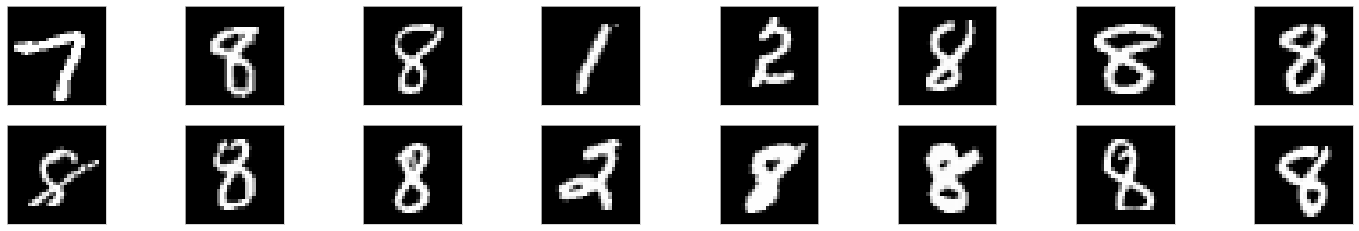

In [0]:
# obtain one batch of training images
images = train_data_ae_t[:batch_size]
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx].reshape(1,28,28)), cmap='gray')

##Define Module Architecture

Encoder and Decoder separatly just in case.

In [0]:
class Encoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(NF, round(lat_r[0]*NF))
        self.fc2 = nn.Linear(round(lat_r[0]*NF), round(lat_r[1]*NF))
        self.fc3 = nn.Linear(round(lat_r[1]*NF), round(lat_r[2]*NF))
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(self.fc3(x)) #Only droput on last layer no ReLu
        return x

class Decoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(round(lat_r[2]*NF), round(lat_r[1]*NF))
        self.fc2 = nn.Linear(round(lat_r[1]*NF), round(lat_r[0]*NF))
        self.fc3 = nn.Linear(round(lat_r[0]*NF), NF)
        self.dropout = nn.Dropout(p=dropout)       
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

In [0]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()

        self.encoder = Encoder(no_features, lat_r, dropout)
        self.decoder = Decoder(no_features, lat_r, dropout)
        
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

##Check GPU aviability

In [0]:
# check if CUDA is available
gpu = torch.cuda.is_available()
if not gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


##Set parameters and define model

In [0]:
#Parameters setting
max_epochs = 6
dropout = 0.2
batch_size = 128
start_lr = 0.005 #Starting learning rate 
no_features = 784

#Learning Rate scheduler
patience = 5 #After how many epochs with no improvemnt change LR
factor = 0.9 #Scale factor of LR 

#Encoding
latent_ratio = [0.5, 0.3, 0.1] #Must be 3 elements

In [0]:
#Create callbacks
model_path = 'skorch_ae_model.pt'
checkpoint = Checkpoint(f_params=model_path, monitor='valid_loss_best')
scheduler = LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss', factor = factor, patience = patience, threshold=1e-3) 

net = NeuralNetRegressor(
    SimpleAutoEncoder,
    module__no_features = no_features,
    module__lat_r = latent_ratio,
    module__dropout = dropout,
    batch_size = batch_size,
    lr=start_lr,
    optimizer = optim.Adam,
    max_epochs=max_epochs,
    train_split=predefined_split(valid_data_ae),
    device='cuda' if gpu else 'cpu',
    callbacks=[checkpoint, scheduler],
    verbose = 1
)
#Default criterion is <class 'torch.nn.modules.loss.MSELoss'>

print(net)

<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.SimpleAutoEncoder'>,
  module__dropout=0.2,
  module__lat_r=[0.5, 0.3, 0.1],
  module__no_features=784,
)


In [0]:
#Initialize network
net.initialize()

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SimpleAutoEncoder(
    (encoder): Encoder(
      (fc1): Linear(in_features=784, out_features=392, bias=True)
      (fc2): Linear(in_features=392, out_features=235, bias=True)
      (fc3): Linear(in_features=235, out_features=78, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (decoder): Decoder(
      (fc1): Linear(in_features=78, out_features=235, bias=True)
      (fc2): Linear(in_features=235, out_features=392, bias=True)
      (fc3): Linear(in_features=392, out_features=784, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  ),
)

##Train Autoencoder

In [0]:
net.fit(train_data_ae, y=None); #output compared with input, hide output

Re-initializing module because the following parameters were re-set: dropout, lat_r, no_features.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0742        0.0600     +  0.3174
      2        0.0555        0.0508     +  0.2995
      3        0.0495        0.0454     +  0.2882
      4        0.0456        0.0408     +  0.3033
      5        0.0422        0.0382     +  0.3272
      6        0.0403        0.0364     +  0.2910


##Test model

In [0]:
#Define function calculating losses of test samples
def aeTestLosses(X_test, X_pred, y_test):
    '''
    X_test, X_pred need to be tensors!
    Return Tensor of outliers MSE and correct samples MSE.
    '''
    outliers = []
    correct = []
    all_scores = []
    loss_func = nn.MSELoss()
    for t,p,l in zip(X_test, X_pred, y_test):
        mse_loss = loss_func(t,p).item()
        all_scores.append(mse_loss)
        if l: #Outlier
            outliers.append(mse_loss)
        else: #Not outlier
            correct.append(mse_loss)     
    return all_scores, outliers , correct

#Define function for MSE vizualisation 
def mseVizualisation(outliers, inliers):
    max_val = max(outliers + inliers)

    fig, ax = plt.subplots(figsize = (20, 3))

    plt.hlines(0,0,max_val)  # Draw a horizontal line
    plt.ylim(-0.5,0.5)

    y1 = np.zeros(np.shape(inliers))
    y2 = np.zeros(np.shape(outliers))    

    plt.plot(inliers,y1,'.',ms = 10, color='blue') 
    plt.plot(outliers,y2,'x',ms = 10, color='red') 

    plt.title('Mean Square Error of Sample Reconstrution.')
    plt.xlabel('MSE')
    plt.legend(['Inliners','Outliers'])

    plt.yticks([])
    plt.show()

#Define function for calculation and visualization of ROC
def rocVizualisation(y_test, pred_scores):
    fpr, tpr, thresholds = roc_curve(y_test, all_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize = (8,6))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('ROC curve')
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC area = %0.3f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()

**Load best model from checkpoint**

In [0]:
#Load model with lowest validation accuracy
net.initialize()  # This is important!
net.load_params(model_path)

Re-initializing module because the following parameters were re-set: dropout, lat_r, no_features.
Re-initializing optimizer.


**Run prediction and evaluate** 

In [0]:
#Run prediction and change to tensor
pred = net.predict(test_data_ae_t)
pred_t = torch.FloatTensor(pred)

#Get MSE of correct test samples and outliers
all_scores, outliers, inliers = aeTestLosses(test_data_ae_t, pred_t, y_test)

Score of AE: 4.07mu


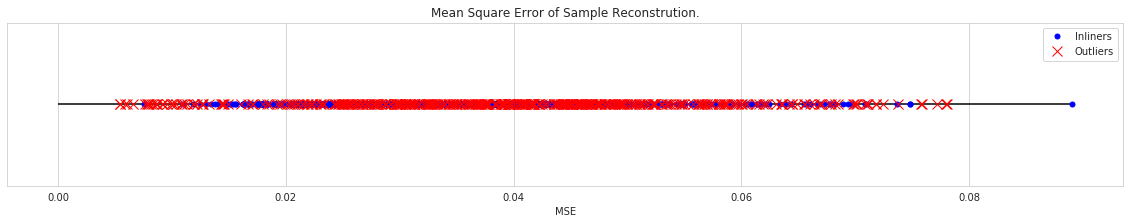

In [0]:
#Count score of autoencoder and vizualize
as_score = sum(outliers)/len(outliers) - sum(inliers)/len(inliers)
print('Score of AE: {:0.2f}mu'.format(as_score*1000))

mseVizualisation(outliers, inliers)

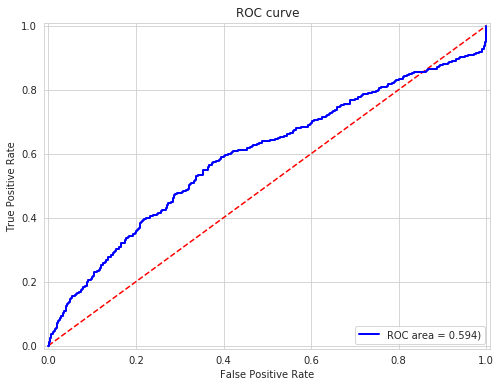

In [0]:
#Show ROC
rocVizualisation(y_test, all_scores)

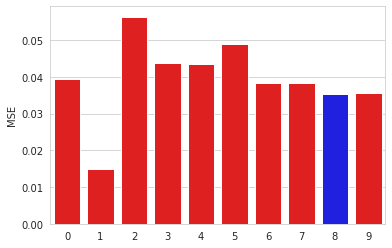

In [0]:
#Check MSE Score for different numbers
score_df = pd.DataFrame(columns = ['Label', 'MSE'])
score_df['Label'] = test_labels
score_df['MSE'] = all_scores

grouped = score_df.groupby(['Label']).mean()
palette =['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'r'] #outliers red

sns.barplot(x=list(range(10)), y=grouped['MSE'], palette = palette)